<a href="https://colab.research.google.com/github/kywch/geo-colab/blob/master/test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
# Install GDAL and Geopandas
!apt install gdal-bin python-gdal python3-gdal --quiet
!apt install python3-rtree --quiet
!pip install git+git://github.com/geopandas/geopandas.git --quiet
!pip install descartes --quiet
!pip install osmnx==0.10
!pip install folium


Reading package lists...
Building dependency tree...
Reading state information...
gdal-bin is already the newest version (2.2.3+dfsg-2).
python-gdal is already the newest version (2.2.3+dfsg-2).
python3-gdal is already the newest version (2.2.3+dfsg-2).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.
Reading package lists...
Building dependency tree...
Reading state information...
python3-rtree is already the newest version (0.8.3+ds-1).
0 upgraded, 0 newly installed, 0 to remove and 31 not upgraded.


In [0]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import folium
import matplotlib.pyplot as plt
import seaborn as sns

from fiona.crs import from_epsg
from shapely.geometry import Point

import requests

Census tract GeoJSON files are available from
https://github.com/loganpowell/census-geojson

So, we just directly retrieve GeoJSON file from this GitHub

In [0]:
gtr = gpd.read_file('https://raw.githubusercontent.com/loganpowell/census-geojson/master/GeoJSON/500k/2019/17/tract.json', 
                   crs = from_epsg(2163)).to_crs(epsg = 3528)

In [0]:
# select Cook county
gtr = gtr[gtr.COUNTYFP == '031']

In [58]:
gtr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1318 entries, 0 to 3120
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   STATEFP   1318 non-null   object  
 1   COUNTYFP  1318 non-null   object  
 2   TRACTCE   1318 non-null   object  
 3   AFFGEOID  1318 non-null   object  
 4   GEOID     1318 non-null   object  
 5   NAME      1318 non-null   object  
 6   LSAD      1318 non-null   object  
 7   ALAND     1318 non-null   int64   
 8   AWATER    1318 non-null   int64   
 9   geometry  1318 non-null   geometry
dtypes: geometry(1), int64(2), object(7)
memory usage: 113.3+ KB


Let's limit our analysis to Chicago. To do that, we need to download the Chicago boundary shapefile.

GeoJSON is available at https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-City/ewy2-6yfk via https://data.cityofchicago.org/api/geospatial/ewy2-6yfk?method=export&format=GeoJSON

In [0]:
chi_bound = gpd.read_file('https://data.cityofchicago.org/api/geospatial/ewy2-6yfk?method=export&format=GeoJSON', 
                   crs = from_epsg(2163)).to_crs(epsg = 3528)

In [43]:
chi_bound

,name,objectid,shape_area,shape_len,geometry
0,CHICAGO,1,6450276623.31,845282.931362,"MULTIPOLYGON (((332989.045 592278.070, 332983...."


In [0]:
gtr = gpd.sjoin(gtr, chi_bound, 
                op='intersects').drop("index_right", axis = 1)

In [61]:
gtr.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 870 entries, 1 to 3120
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP     870 non-null    object  
 1   COUNTYFP    870 non-null    object  
 2   TRACTCE     870 non-null    object  
 3   AFFGEOID    870 non-null    object  
 4   GEOID       870 non-null    object  
 5   NAME        870 non-null    object  
 6   LSAD        870 non-null    object  
 7   ALAND       870 non-null    int64   
 8   AWATER      870 non-null    int64   
 9   geometry    870 non-null    geometry
 10  name        870 non-null    object  
 11  objectid    870 non-null    object  
 12  shape_area  870 non-null    object  
 13  shape_len   870 non-null    object  
dtypes: geometry(1), int64(2), object(11)
memory usage: 102.0+ KB


Let's get the population info

In [0]:
json = requests.get("https://api.census.gov/data/2018/acs/acs5/" + 
                    "?get=B01001_001E&for=tract:*&in=state:17").json()

pops = pd.DataFrame(columns = json[0], data = json[1:])
pops = pops[pops.county == "031"]

In [63]:
pops.head()

,B01001_001E,state,county,tract
19,5391,17,031,310900
20,1659,17,031,420500
21,2756,17,031,430400
22,1920,17,031,430600
23,2547,17,031,440900


In [0]:
pops["GEOID"] = (pops["state"] + pops["county"] + pops["tract"])
pops["res"] = pops["B01001_001E"].astype(int)

pops = pops[["GEOID", "res"]]

In [0]:
def map_format(ax, on = False):
    
    plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, hspace = 0, wspace = 0)
    plt.margins(0,0)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    if not on:
        ax.set_axis_off()
        ax.set_axis_on()
        for a in ["bottom", "top", "right", "left"]:
            ax.spines[a].set_linewidth(0)
    
    return ax

In [0]:
pop_gdf = pd.merge(gtr, pops, 
                   left_on = "GEOID", right_on="GEOID", how = "left")

In [67]:
pop_gdf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 870 entries, 0 to 869
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP     870 non-null    object  
 1   COUNTYFP    870 non-null    object  
 2   TRACTCE     870 non-null    object  
 3   AFFGEOID    870 non-null    object  
 4   GEOID       870 non-null    object  
 5   NAME        870 non-null    object  
 6   LSAD        870 non-null    object  
 7   ALAND       870 non-null    int64   
 8   AWATER      870 non-null    int64   
 9   geometry    870 non-null    geometry
 10  name        870 non-null    object  
 11  objectid    870 non-null    object  
 12  shape_area  870 non-null    object  
 13  shape_len   870 non-null    object  
 14  res         870 non-null    int64   
dtypes: geometry(1), int64(3), object(11)
memory usage: 108.8+ KB


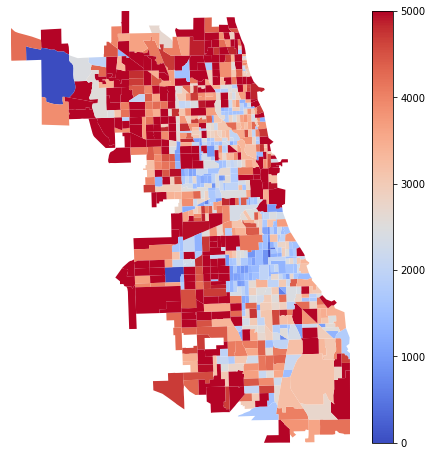

In [68]:
ax = pop_gdf.plot(column = "res", vmin = 0, vmax = 5000, 
                  figsize = (6, 6), legend = True, cmap = "coolwarm")

map_format(ax)